(INFO) (ctf.py) (24-Aug-24 15:27:43) Image size (pix)  : 64
(INFO) (ctf.py) (24-Aug-24 15:27:43) A/pix             : 8.5
(INFO) (ctf.py) (24-Aug-24 15:27:43) DefocusU (A)      : 23552.5
(INFO) (ctf.py) (24-Aug-24 15:27:43) DefocusV (A)      : 23740.400390625
(INFO) (ctf.py) (24-Aug-24 15:27:43) Dfang (deg)       : 86.61000061035156
(INFO) (ctf.py) (24-Aug-24 15:27:43) voltage (kV)      : 300.0
(INFO) (ctf.py) (24-Aug-24 15:27:43) cs (mm)           : 2.700000047683716
(INFO) (ctf.py) (24-Aug-24 15:27:43) w                 : 0.07000000029802322
(INFO) (ctf.py) (24-Aug-24 15:27:43) Phase shift (deg) : 0.0
(INFO) (simulator.py) (24-Aug-24 15:27:43) Loading volume 0
(INFO) (simulator.py) (24-Aug-24 15:27:44) Loading volume 0
(INFO) (simulator.py) (24-Aug-24 15:27:45) Batch 0: Generated 1000 images so far
(INFO) (simulator.py) (24-Aug-24 15:27:45) Batch 1: Generated 2000 images so far
(INFO) (simulator.py) (24-Aug-24 15:27:45) Batch 2: Generated 3000 images so far
(INFO) (simulator.py) (24-A

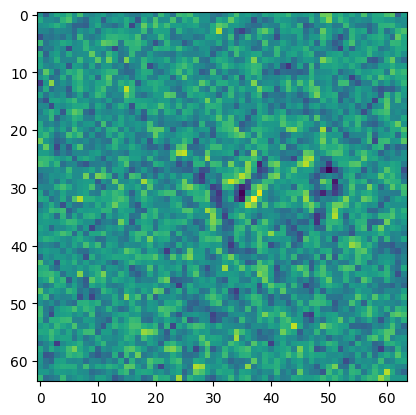

In [15]:
import recovar.config
import aspire
from aspire.utils.bot_align import align_BO
from importlib import reload
import numpy as np
from cryodrgn import utils
from cryodrgn import ctf
from recovar import plot_utils
from recovar import output, dataset
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objs as go
import plotly.offline as py
from recovar import simulator
from recovar.fourier_transform_utils import fourier_transform_utils
import time
import jax.numpy as jnp
ftu = fourier_transform_utils(jnp)

reload(simulator)
import jax
import warnings
from recovar import utils
# warnings.filterwarnings("error")
grid_size =64
for log_n in [3]:
    # output_folder ='/home/mg6942/mytigress/spike256/../'
    volume_folder_input =  f"/tigress/CRYOEM/singerlab/mg6942/simulated_empiar10180/volumes_128_small/three_vols/vol"
    volume_folder_input = "/scratch/gpfs/mg6942/cooperative/models/three_volumes/"
    volume_folder_input = "/scratch/gpfs/mg6942/cooperative/models/renamed/"

    # output_folder = volume_folder_input+ f"/dataset_3e{log_n}_radial_contrast_01/"
    noise_level = 0.5
    # output_folder = f"/tigress/CRYOEM/singerlab/mg6942/two_vols/{noise_level:.1e}_{log_n}_nocont_{grid_size}/"
    
    output_folder = f"/tigress/CRYOEM/singerlab/mg6942/two_vols/{noise_level:.1e}_{log_n}_nocont_{grid_size}/"
    outlier_file_input = "/home/mg6942/mytigress/6vxx_256.mrc"
    n_images =  10* int(10**(log_n))
    voxel_size = 4.25 * 128 / grid_size #f"{output_folder}../spike{grid_size}_small/0000.mrc"
    output.mkdir_safe(output_folder)
    
    volume_distribution = np.zeros(50)
    # volume_distribution[0] = 1
    # volume_distribution[1] = 1/3
    # volume_distribution[-1] = 1/3
    volume_distribution = None
    do_it = False
    if do_it:
        image_stack, sim_info = simulator.generate_synthetic_dataset(output_folder, voxel_size, volume_folder_input, n_images,
                                                                     outlier_file_input = outlier_file_input, grid_size = grid_size,
                                       volume_distribution = volume_distribution,  dataset_params_option = "uniform", noise_level = noise_level,
                                       noise_model = "radial1", put_extra_particles = False, percent_outliers = 0.00, 
                                       volume_radius = 0.7, trailing_zero_format_in_vol_name = True, noise_scale_std = 0.2 * 0, contrast_std =0.2 *0  , disc_type = 'linear_interp', n_tilts = -1, 
                                                                    )
        print(f"Finished generating dataset {output_folder}")
        del image_stack, sim_info


from importlib import reload
# import recovar.config

import healpy as hp
import matplotlib.pyplot as plt
from cryodrgn import utils as cryodrgn_utils
import numpy as np
import jax.numpy as jnp
def angle_grid(level):

    NSIDE = 2**level
    nside = NSIDE
    m = hp.nside2npix(NSIDE)

    z = hp.pix2ang(nside, np.arange(m))

    angle_res = hp.nside2resol(nside, arcmin=True) / 60 
    n_in_planes = np.round(360 / angle_res).astype(int)
    in_angle_angles = np.linspace(0, 2 * np.pi, n_in_planes)

    angles = np.meshgrid( np.arange(m), in_angle_angles )
    theta = z[0][angles[0]]
    phi = z[1][angles[0]]
    angles = np.stack( [theta, phi, angles[1] ], axis=-1)
    angles = angles.reshape( -1, 3)

    from cryodrgn import utils as cryodrgn_utils
    rotation_matrices = np.array([cryodrgn_utils.R_from_relion(*angle) for angle in angles])
    return rotation_matrices


def get_healpix_sampling(nside_level, n_in_planes = None):

    #  * order	Npix	Theta-sampling
    #  * 0		12		58.6
    #  * 1		48		29.3
    #  * 2		192		14.7
    #  * 3		768		7.33
    #  * 4		3072	3.66
    #  * 5		12288	1.83
    #  * 6		49152	0.55
    #  * 7		196608	0.28
    #  * 8		786432	0.14

    nside = 2**nside_level
    m = hp.nside2npix(nside)
    z = hp.pix2ang(nside, np.arange(m))

    if n_in_planes is None:
        #RELION does this:
        angle_res = 360 / ( 6 * 2**nside_level)
        # angle_res = hp.nside2resol(nside, arcmin=True) / 60 
        n_in_planes = np.round(360 / angle_res).astype(int)

    in_angle_angles = np.linspace(0, 2 * np.pi, n_in_planes, endpoint=False)
    angles = np.meshgrid( np.arange(m), in_angle_angles )
    theta = z[0][angles[0]]
    phi = z[1][angles[0]]
    angles = np.stack( [theta, phi, angles[1] ], axis=-1)
    angles = angles.reshape( -1, 3)
    return angles / (2 * np.pi) * 360

def get_angle_resolution(nside_level):
    nside = 2**nside_level
    return hp.nside2resol(nside, arcmin=True) / 60

def get_translation_grid(max_pixel, pixel_offset):
    gridded_max_pixel = (max_pixel // pixel_offset ) * pixel_offset 
    # xrange_one_sided = np.arange(0, max_pixel//2 + 1, pixel_offset)
    xrange = np.arange(-gridded_max_pixel, gridded_max_pixel + 1, pixel_offset)
    x, y = np.meshgrid(xrange, xrange)
    grid = np.stack([x.flatten(), y.flatten()], axis = 1)
    norm_res = np.linalg.norm(grid, axis = 1) <= max_pixel + 0.001
    grid = grid[norm_res] 
    return grid


healpix_order = 2 # 2
angles = get_healpix_sampling(healpix_order, n_in_planes = None)
translation_grid = get_translation_grid(5, 2)
rotation_matrices = np.array([cryodrgn_utils.R_from_relion(*angle) for angle in angles])


# vv = angle_grid(1)

from recovar import dataset, simulator, utils
from recovar import regularization, synthetic_dataset, noise, homogeneous, utils, adaptive_kernel_discretization, utils, EM_iteration

dataset_dict = dataset.get_default_dataset_option()

# grid_size = 256
# output_folder = 'test_dataset/'
dataset_dict['ctf_file'] = output_folder + "ctf.pkl"
dataset_dict['poses_file'] = output_folder + "poses.pkl"
dataset_dict['particles_file'] = f"{output_folder}particles.{grid_size}.mrcs"

# Returns an object that knows everything about the dataset.
cryo = dataset.load_dataset_from_dict(dataset_dict, lazy = False)

# Pick some random rotations
rot_indices = np.random.choice(np.arange(angles.shape[0]), size = cryo.n_images, replace = True) * 1 
trans_indices = np.random.choice(np.arange(translation_grid.shape[0]), size = cryo.n_images, replace = True)
# cryo.rotation_matrices = rotation_matrices[rot_indices]
# cryo.translations = translation_grid[trans_indices]


disc_type = 'linear_interp'

sim_info = utils.pickle_load(output_folder + '/simulation_info.pkl')
gt_recon = synthetic_dataset.load_heterogeneous_reconstruction(sim_info, volumes_path_root = None)
gt_vol =gt_recon.volumes
noise_variance = sim_info['noise_variance']
HH = synthetic_dataset.load_heterogeneous_reconstruction(sim_info, volumes_path_root = None)
gt_mean = HH.get_mean()
signal_variance = utils.make_radial_image(regularization.average_over_shells(np.abs(gt_mean)**2, HH.volume_shape), HH.volume_shape)
downsampled_mean = gt_mean * cryo.get_valid_frequency_indices(rad = 5)

noise_variance = noise_variance * 1
noise_variance_inp = noise_variance.copy()
images = simulator.simulate_data(cryo, gt_vol,  noise_variance,  1000, np.random.randint(0, gt_recon.volumes.shape[0], cryo.n_images)*0 , np.ones(cryo.n_images), np.ones(cryo.n_images), seed =0, disc_type = disc_type, mrc_file = None, pad_before_translate = False, Bfactor=100 )
gt_poses = cryo.rotation_matrices.copy()
gt_trans = cryo.translations.copy()
#cryo.image_stack.particles = images

import matplotlib.pyplot as plt
plt.imshow(cryo.get_image_real(0))


def estimate_error(probabilities, true_rot_indices, true_trans_indices):
    
    hard_assignment = np.argmax(probabilities.reshape((*probabilities.shape[:-2], -1) ), axis=-1)
    maxpos_vect = np.column_stack(np.unravel_index(hard_assignment,probabilities.shape[-2:]))
    predicted_trans = translation_grid[maxpos_vect[:,1]]
    gt_trans = translation_grid[true_trans_indices]

    predicted_pose = rotation_grid[maxpos_vect[:,0]]
    gt_pose = rotation_grid[true_rot_indices]
    from scipy.spatial.transform import Rotation as R
    predicted_pose = R.from_matrix(predicted_pose)
    gt_pose = R.from_matrix(gt_pose)
    error = (predicted_pose * gt_pose.inv()).magnitude() / np.pi * 180
    # error 
    # rots_2 =  rots * rots[0].inv() 

    print('mean trans error:', np.mean(np.linalg.norm(predicted_trans - gt_trans, axis=-1)),' pixels')
    print('mean angle error:', np.mean(error), 'degrees')
    
    return 


def estimate_error2(probabilities, gt_pose, gt_trans):
    
    hard_assignment = np.argmax(probabilities.reshape((*probabilities.shape[:-2], -1) ), axis=-1)
    maxpos_vect = np.column_stack(np.unravel_index(hard_assignment,probabilities.shape[-2:]))
    predicted_trans = translation_grid[maxpos_vect[:,1]]
    # gt_trans = translation_grid[true_trans_indices]
    predicted_pose = rotation_grid[maxpos_vect[:,0]]
    # gt_pose = rotation_grid[true_rot_indices]
    from scipy.spatial.transform import Rotation as R
    predicted_pose = R.from_matrix(predicted_pose)
    gt_pose = R.from_matrix(gt_pose)
    error = (predicted_pose * gt_pose.inv()).magnitude() / np.pi * 180
    # error 
    # rots_2 =  rots * rots[0].inv() 

    print('mean trans error:', np.mean(np.linalg.norm(predicted_trans - gt_trans, axis=-1)),' pixels')
    print('mean angle error:', np.mean(error), 'degrees')
    
    return 


def estimate_error3(probabilities, true_rot_indices, true_trans_indices):
    
    hard_assignment = np.argmax(probabilities.reshape((*probabilities.shape[:-2], -1) ), axis=-1)
    
    rot_trans_indices = np.unravel_index(hard_assignment,probabilities.shape[-2:])
    
    maxpos_vect = np.column_stack(np.unravel_index(hard_assignment,probabilities.shape[-2:]))
    predicted_trans = translation_grid[maxpos_vect[:,1]]
    gt_trans = translation_grid[true_trans_indices]

    predicted_pose = rotation_grid[maxpos_vect[:,0]]
    gt_pose = rotation_grid[true_rot_indices]
    from scipy.spatial.transform import Rotation as R
    predicted_pose = R.from_matrix(predicted_pose)
    gt_pose = R.from_matrix(gt_pose)
    error = (predicted_pose * gt_pose.inv()).magnitude() / np.pi * 180
    # error 
    # rots_2 =  rots * rots[0].inv() 

    print('mean trans error:', np.mean(np.linalg.norm(predicted_trans - gt_trans, axis=-1)),' pixels')
    print('mean angle error:', np.mean(error), 'degrees')
    
    return 




In [16]:
from cryodrgn.commands import parse_pose_csparc 

In [17]:
import argparse
import os.path

J = '8'

dirr = '/home/mg6942/mytigress/CS-ab-het/'
cs_particles = f'{dirr}/J{J}/J{J}_000_particles.cs'


for k in range(1000):
    cs_particles = f'/home/mg6942/mytigress/CS-ab-het/J{J}/J{J}_'+format(k, '05d')+'_particles.cs'
    if os.path.isfile(cs_particles):
        break
        
J = '13'
cs_particles = f'/home/mg6942/mytigress/CS-ab-het/J{J}/J{J}_001_particles.cs'
print(cs_particles)
        
        
# parse_pose_csparc.(cs_particles)
commands = ['',  cs_particles, '-D', str(grid_size), '-o', 'poses.pkl']

parser = argparse.ArgumentParser(commands)
# main(argsinp( 

        
def load_poses(cs_particles, D ):
    class argsinp:
        def __init__(self, input_cs, o, D, hetrefine=False):
            self.input = input_cs
            self.o = o
            self.D = D
            self.hetrefine=False
            self.abinit=False

    tmpdir = '/tmp/pose.pkl'
    args = argsinp(cs_particles, tmpdir, D)
    parse_pose_csparc.main(args)
    vv = recovar.utils.pickle_load(tmpdir)
    return vv[0], vv[1] * D

def load_volumes(dirr, J):
    return recovar.utils.load_mrc( f'{dirr}/J{J}/J{J}_000_volume_map.mrc')

poses = load_poses(cs_particles, cryo.grid_size )
mean = load_volumes(dirr, J)

/home/mg6942/mytigress/CS-ab-het/J13/J13_001_particles.cs
0 uid 4500884250452520729
1 blob/path b'J1/imported/004500884250452520729_particles.64.mrcs'
2 blob/idx 0
3 blob/shape [64 64]
4 blob/psize_A 8.5
5 blob/sign 1.0
6 blob/import_sig 14984625544561899476
7 ctf/type b'imported'
8 ctf/exp_group_id 1
9 ctf/accel_kv 300.0
10 ctf/cs_mm 2.7
11 ctf/amp_contrast 0.07
12 ctf/df1_A 23552.5
13 ctf/df2_A 23740.4
14 ctf/df_angle_rad 1.5116297
15 ctf/phase_shift_rad 0.0
16 ctf/scale 1.0
17 ctf/scale_const 0.0
18 ctf/shift_A [0. 0.]
19 ctf/tilt_A [0. 0.]
20 ctf/trefoil_A [0. 0.]
21 ctf/tetra_A [0. 0. 0. 0.]
22 ctf/anisomag [0. 0. 0. 0.]
23 ctf/bfactor 0.0
24 alignments3D/split 0
25 alignments3D/shift [-6.553125  0.065625]
26 alignments3D/pose [ 1.0764163  1.391978  -0.753842 ]
27 alignments3D/psize_A 8.5
28 alignments3D/error 1207.3104
29 alignments3D/error_min 0.0
30 alignments3D/resid_pow 1500.6108
31 alignments3D/slice_pow 125.04777
32 alignments3D/image_pow 1352.9089
33 alignments3D/cross_cor

In [18]:
poses

(array([[[ 0.08588129,  0.17579234, -0.98067397],
         [ 0.91737056,  0.370027  ,  0.1466673 ],
         [ 0.38865882, -0.91223735, -0.12948835]],
 
        [[-0.76621056, -0.44668722, -0.46194324],
         [ 0.05754107, -0.7636837 ,  0.643021  ],
         [-0.64000785,  0.4661089 ,  0.6108457 ]],
 
        [[-0.19070148,  0.703709  , -0.68441707],
         [ 0.09233919, -0.68126154, -0.72619313],
         [-0.97729546, -0.2016846 ,  0.06493759]],
 
        ...,
 
        [[-0.28209317,  0.5443252 , -0.7900212 ],
         [ 0.9592044 ,  0.14395523, -0.24331817],
         [-0.01871657, -0.8264302 , -0.5627279 ]],
 
        [[ 0.63627183, -0.5163225 ,  0.57320964],
         [-0.21207891,  0.5973218 ,  0.77345276],
         [-0.74174166, -0.6136919 ,  0.27055794]],
 
        [[ 0.22477949,  0.81431836, -0.535126  ],
         [ 0.87611336, -0.4092741 , -0.2547943 ],
         [-0.42649683, -0.4115585 , -0.8054315 ]]], dtype=float32),
 array([[-6.553125,  0.065625],
        [-2.203125, 

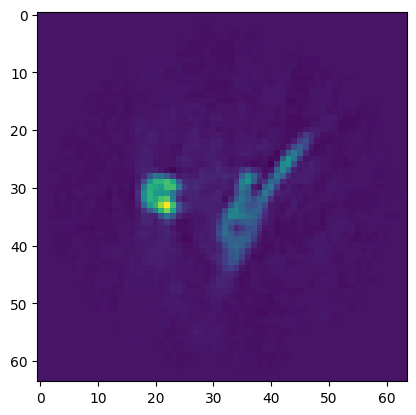

In [19]:
from recovar import core
plt.imshow(mean.sum(axis=0))
# shifted_particles = np.zeros_like(cryo.image_stack.particles)
# dfted_parts = ftu.get_dft2(cryo.image_stack.particles)
# shifted_dfted_parts = core.translate_images(dfted_parts.reshape(dfted_parts.shape[0], -1), poses[1], cryo.image_shape)
# cryo.image_stack.particles =  ftu.get_idft2(shifted_dfted_parts.reshape(-1, *cryo.image_shape)).real
cryo.rotation_matrices = poses[0]
cryo.translations = poses[1]


In [20]:
from scipy.spatial.transform import Rotation as R
# cryo.rotation_matrices =  R.random(cryo.n_images).as_matrix()
from recovar import relion_functions, core
mean_prior = 1/signal_variance
noise_variance_rad = noise.make_radial_noise(noise_variance, cryo.image_shape)
init, _ = relion_functions.relion_reconstruct(cryo, noise_variance_rad,100, upsampling_factor = 1, tau = 1/mean_prior )


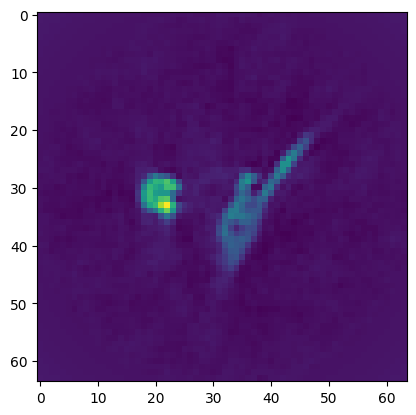

In [21]:
plt.imshow(cryo.get_proj(init, axis=0))
plt.imshow(cryo.get_proj(init, axis=0))

In [8]:
asdasda

NameError: name 'asdasda' is not defined

In [ ]:
plt.imshow(cryo.get_proj(init))

In [ ]:
from scipy.spatial.transform import Rotation as R
cryo.rotation_matrices =  R.random(cryo.n_images).as_matrix()
from recovar import relion_functions, core
mean_prior = 1/signal_variance
noise_variance_rad = noise.make_radial_noise(noise_variance, cryo.image_shape)
experiment_dataset = cryo
rotation_grid = rotation_matrices
translation_grid =  translation_grid#np.mgrid[-2:3,-2:3].reshape(2, -1).T * 1


cryo.CTF_params[10:,core.contrast_ind] =0 
init, _ = relion_functions.relion_reconstruct(cryo, noise_variance_rad,100, upsampling_factor = 1, tau = 1/mean_prior )
cryo.CTF_params[10:,core.contrast_ind] =1 

cryo.CTF_params[20:,core.contrast_ind] =0 
cryo.CTF_params[:10,core.contrast_ind] =0 

init2, _ = relion_functions.relion_reconstruct(cryo, noise_variance_rad,100, upsampling_factor = 1, tau = 1/mean_prior )
cryo.CTF_params[:,core.contrast_ind] =1 


# noise_variance_rad = noise.make_radial_noise(noise_variance, cryo.image_shape)
# experiment_dataset = cryo
# rotation_grid = rotation_matrices
# translation_grid =  translation_grid#np.mgrid[-2:3,-2:3].reshape(2, -1).T * 1


In [ ]:
reload(dataset)
ind = np.arange(n_images)
ind = [ind[:n_images//2] , ind[n_images//2:]]
if 'ind' in dataset_dict:
    del dataset_dict['ind']
cryos = dataset.get_split_datasets_from_dict(dataset_dict, ind_split = ind, lazy = False)

In [22]:
plt.imshow(cryos[0].get_image_real(0))

NameError: name 'cryos' is not defined

In [23]:
def get_sgd_projection(k):
    def proj(x):
        return x * cryo.get_valid_frequency_indices(k)
    return proj


import logging.config
logging.config.dictConfig({
    'version': 1,
    'disable_existing_loggers': True,
})



In [ ]:
plt.figure()
plt.imshow(cryo.get_proj(sgd_proj(gt_mean[:])))
plt.show()


In [ ]:
# init = init.reshape(-1)
means = [init.reshape(-1), init2.reshape(-1) ]

# means = [  mean * cryo.get_valid_frequency_indices(10).reshape(-1) for mean in means]


sgd_updates = [0,0]
mean_signal_variance = signal_variance.copy() / 1
reload(EM_iteration)
image_shape = cryo.image_shape
volume_shape = cryo.volume_shape
reload(EM_iteration)
noise_variance = 4 * noise.make_radial_noise(noise_variance_inp[:31] + regularization.average_over_shells(mean_signal_variance, volume_shape ) , cryo.image_shape)
current_pixel_res =0
init_res = 10 
# noise_variance = noise_variance_rad + signal_variance
do_nothing_for_k_iter = 1

low_res_mask = cryo.get_valid_frequency_indices(current_pixel_res)
means = [np.array(mean) for mean in means ]
means[0][low_res_mask] = (means[0][low_res_mask] + means[1][low_res_mask])/2
means[1][low_res_mask] = means[0][low_res_mask]
average_up_to_angstrom = current_pixel_res
means = [  mean * cryo.get_valid_frequency_indices(init_res).reshape(-1) for mean in means]

for k in range(10):
    sgd_proj = get_sgd_projection( init_res if k < do_nothing_for_k_iter else 5 + 5 * k)
    means, mean_signal_variance, current_pixel_res, noise_variance, sgd_updates = EM_iteration.split_E_M(cryos, means, mean_signal_variance, rotation_grid, translation_grid, 
                   noise_variance, disc_type, heterogeneous = False, 
                   us = None, ss = None, bases = None, sgd=True, sgd_batchsize = 100, sgd_updates = sgd_updates, average_up_to_angstrom = average_up_to_angstrom, sgd_projection = None)
    # if k < 4:
    #     means[0] *= cryo.get_valid_frequency_indices(10)
    #     means[1] *= cryo.get_valid_frequency_indices(10)
    # if k < 1:
    #     current_pixel_res = np.min([current_pixel_res, 5])
        
    # if k < do_nothing_for_k_iter:
    #     mean_signal_variance = signal_variance.copy() / 1
    average_up_to_angstrom = np.min([20, current_pixel_res])
    
    # print(current_res)
    plt.figure()
    plt.semilogy(noise_variance_inp[:cryo.grid_size//2], label = 'gt noise')
    plt.semilogy(regularization.average_over_shells(signal_variance,volume_shape)[:cryo.grid_size//2], label = 'gt signal')
    plt.semilogy(regularization.average_over_shells(noise_variance, image_shape )[:cryo.grid_size//2], label = 'noise')
    plt.semilogy(regularization.average_over_shells(mean_signal_variance, volume_shape )[:cryo.grid_size//2], label = 'signal')
    plt.legend()
    plt.show()
    from recovar import mask as mask_fn

    spatial_mask = mask_fn.raised_cosine_mask(volume_shape, grid_size//2 -3, grid_size//2, -1).reshape(-1)
    fourier_mask = mask_fn.raised_cosine_mask(volume_shape, current_pixel_res + 10, current_pixel_res + 13, 0).reshape(-1)

    for mean in means:
        mean = ftu.get_idft3(mean.reshape(volume_shape))
        mean = mean.real
        mean = np.array(mean)
        mean[mean < 0] = 0 
        mean *= spatial_mask.reshape(mean.shape)
        mean = ftu.get_dft3(mean)
        # if k < 3:
        mean *= fourier_mask.reshape(mean.shape)
        plt.figure()
        plt.imshow(cryo.get_proj(mean[:]))
        plt.show()        
    print("iter", k, "done")

In [ ]:
from aspire.volume import Volume
vol1 = Volume(np.array(ftu.get_idft3(gt_mean.reshape(volume_shape)).real.astype(np.float64)))
vol2 = Volume(np.array(ftu.get_idft3(means[0].reshape(volume_shape)).real.astype(np.float64)))

In [ ]:
aligned_rots = align_BO(vol1, vol2)

In [ ]:
from aspire.utils.rotation import Rotation
inv = lambda  x : x#np.linalg.inv(x)
plt.imshow(np.array(vol2.rotate(Rotation(inv(aligned_rots[1]))))[0].sum(axis=0))
plt.figure()
plt.imshow(np.array(vol1)[0].sum(axis=0))

# plt.imshow(np.array(vol2.rotate(Rotation(vol_aligned[1])))[0].sum(axis=0))

In [ ]:
import copy
init_means = copy.deepcopy(means)
# init_means = [mean, mean]

In [ ]:
reload(EM_iteration)

means = copy.deepcopy(init_means)
healpix_order = 2 # 2
angles = get_healpix_sampling(healpix_order, n_in_planes = None)
rotation_matrices = np.array([cryodrgn_utils.R_from_relion(*angle) for angle in angles])

for k in range(4):
    
    means, mean_signal_variance, current_pixel_res, noise_variance, sgd_updates = EM_iteration.split_E_M(cryos, means, mean_signal_variance, rotation_grid, translation_grid, 
                   noise_variance, disc_type, heterogeneous = False, 
                   us = None, ss = None, bases = None, sgd=False, sgd_batchsize = 100, sgd_updates = sgd_updates, average_up_to_angstrom = average_up_to_angstrom, sgd_projection = get_sgd_projection( init_res if k < do_nothing_for_k_iter else current_pixel_res + 5))
    # if k < 4:
    #     means[0] *= cryo.get_valid_frequency_indices(10)
    #     means[1] *= cryo.get_valid_frequency_indices(10)
    # if k < 1:
    #     current_pixel_res = np.min([current_pixel_res, 5])
        
    if k < do_nothing_for_k_iter:
        mean_signal_variance = signal_variance.copy() / 1
        
    
    average_up_to_angstrom = np.min([20, current_pixel_res])
    # print(current_res)
    plt.figure()
    plt.semilogy(noise_variance_inp, label = 'gt noise')
    plt.semilogy(regularization.average_over_shells(signal_variance,volume_shape), label = 'gt signal')
    plt.semilogy(regularization.average_over_shells(noise_variance, image_shape ), label = 'noise')
    plt.semilogy(regularization.average_over_shells(mean_signal_variance, volume_shape ), label = 'signal')
    plt.legend()
    plt.show()
    
    for mean in means:
        mean = ftu.get_idft3(mean.reshape(volume_shape))
        mean = mean.real
        mean = np.array(mean)
        mean[mean < 0] = 0 
        mean *= cryo.get_valid_frequency_indices().reshape(mean.shape)
        mean = ftu.get_dft3(mean).reshape(-1)
        # if k < 3:
        mean *= cryo.get_valid_frequency_indices(current_pixel_res + 10)
        plt.figure()
        plt.imshow(cryo.get_proj(mean[:]))
        plt.show()


In [ ]:
pdb

In [ ]:
plt.imshow(cryo.get_proj(means[0],axis=2))

In [ ]:
blow_res_mask = cryo.get_valid_frequency_indices(current_pixel_res)

In [ ]:
cryo.get_valid_frequency_indices(5).sum()

In [ ]:
noise_from_res, _, _ = noise.get_average_residual_square_just_mean(cryos[0], None, gt_mean, 100, disc_type = 'linear_interp', subset_indices = np.arange(1000), subset_fn = None)


In [ ]:
plt.semilogy(noise_from_res)
plt.semilogy(noise_variance_inp*1)

In [ ]:
k 

In [ ]:
plt.figure()
plt.semilogy(regularization.average_over_shells(noise_variance, image_shape ), label = 'noise')
plt.semilogy(regularization.average_over_shells(mean_signal_variance, volume_shape ), label = 'signal')
plt.legend()
plt.show()


In [ ]:
pdb

In [ ]:
noise_variance_rad = noise.make_radial_noise(noise_variance, cryo.image_shape)
experiment_dataset = cryo
rotation_grid = rotation_matrices
translation_grid =  translation_grid#np.mgrid[-2:3,-2:3].reshape(2, -1).T * 1

from recovar import covariance_core, covariance_estimation
picked_frequencies = np.array(covariance_core.get_picked_frequencies(cryo.volume_shape, radius = 8, use_half = True))
picked_frequency_indices = picked_frequencies[::100]
u, s = HH.get_covariance_eigendecomposition()
n_pcs = gt_vol.shape[0]-1
u = u [:,:n_pcs]
s = s[:n_pcs]
z_gt = jnp.conj(u).T @(gt_vol.T - gt_mean[...,None])
print(z_gt[:,0].real)



In [ ]:
# cryo

In [ ]:
from scipy.spatial.transform import Rotation as R
cryo.rotation_matrices =  R.random(cryo.n_images).as_matrix()
from recovar import relion_functions, core
mean_prior = 1/signal_variance

cryo.CTF_params[10:,core.contrast_ind] =0 
init, _ = relion_functions.relion_reconstruct(cryo, noise_variance_rad,100, upsampling_factor = 1, tau = 1/mean_prior )
cryo.CTF_params[10:,core.contrast_ind] =1 

from recovar.fourier_transform_utils import fourier_transform_utils
import time
ftu = fourier_transform_utils(jnp)
disc_type_mean = disc_type
disc_type_u = disc_type
reload(EM_iteration)
mean = init.copy()#downsampled_mean.copy() 
# mean = gt_mean
# mean= ftu.get_idft3(np.random.randn(*cryo.volume_shape)).reshape(-1) * cryo.get_valid_frequency_indices(cryo.grid_size//4)
batch_size = 1000
# probs = EM_iteration.E_with_precompute(cryo, mean, rotation_grid, translation_grid,noise_variance_rad, disc_type)#, u=u.T, s=s * 1e0)
options = covariance_estimation.get_default_covariance_computation_options()
options['mask_images_in_H_B'] = False
options['disc_type'] = 'linear_interp'

import logging.config
logging.config.dictConfig({
    'version': 1,
    'disable_existing_loggers': True,
})


# RELION
## grad_ini_subset_size = XMIPP_MAX(XMIPP_MIN(dataset_size * 0.005, 5000), 200);
## grad_fin_subset_size = XMIPP_MAX(XMIPP_MIN(dataset_size * 0.1, 50000), 1000);

first_k = 1000
use_het = False
volume_shape = experiment_dataset.volume_shape
mean = mean.reshape(-1)
update =0 
for k in range(20):
    mean = ftu.get_idft3(mean.reshape(volume_shape))
    mean = mean.real
    mean = np.array(mean)
    mean[mean < 0] = 0 
    mean = ftu.get_dft3(mean).reshape(-1)
    plt.figure()
    plt.imshow(cryo.get_proj(mean[:]))
    plt.show()

    mean, update = EM_iteration.E_M_batches(experiment_dataset, mean, rotation_grid, translation_grid,
                                    noise_variance_rad, disc_type, memory_to_use = 128, sgd = True,
                                    sgd_stepsize = 0.5 * 200, sgd_batchsize = 300, mean_prior = 4 * mean_prior, update = update)
    # mean = ftu.get_idft3(mean.reshape(volume_shape))
    # mean = mean.real
    # mean[mean < 0] = 0 
    # mean = ftu.get_dft3(mean).reshape(-1)
    
    print('ohh')
    # plt.figure()
    # plt.imshow(cryo.get_proj(mean[:]))
    # plt.show()



In [ ]:
from recovar.fourier_transform_utils import fourier_transform_utils
import time
ftu = fourier_transform_utils(jnp)
disc_type_mean = disc_type
disc_type_u = disc_type
reload(EM_iteration)
init = mean.copy()
# mean = init.copy()#downsampled_mean.copy() 
# mean= ftu.get_idft3(np.random.randn(*cryo.volume_shape)).reshape(-1) * cryo.get_valid_frequency_indices(cryo.grid_size//4)
batch_size = 1000
# probs = EM_iteration.E_with_precompute(cryo, mean, rotation_grid, translation_grid,noise_variance_rad, disc_type)#, u=u.T, s=s * 1e0)
options = covariance_estimation.get_default_covariance_computation_options()
options['mask_images_in_H_B'] = False
options['disc_type'] = 'linear_interp'

first_k = 1000
use_het = False
for k in range(100):
    st_time = time.time()
    mean_prior = 1/signal_variance
    if k == first_k:
        use_het = True
    
    if k <= first_k or not use_het:
        probs = EM_iteration.E_with_precompute(cryo, mean, rotation_grid, translation_grid,noise_variance_rad, disc_type)#, u=u.T, s=s * 1e0)
    else:
        probs = EM_iteration.E_with_precompute(cryo, mean, rotation_grid, translation_grid,noise_variance_rad, disc_type, u=U_est.T, s=s_est)
    
    print("Done with E step", time.time() - st_time)
    # residuals = EM_iteration.E_with_precompute(experiment_dataset, volume, rotations, translations, noise_variance, disc_type, big_image_batch)
    Ft_y_this, Ft_CTF_this = EM_iteration.M_with_precompute(experiment_dataset, probs, rotation_grid, translation_grid, noise_variance_rad, disc_type)
    mean = Ft_y_this/ (Ft_CTF_this + mean_prior )#+ mean_prior)
    mean *= experiment_dataset.get_valid_frequency_indices(10 + k)
    print("Done with mean", time.time() - st_time)

    mult = 10**(5+first_k-k)
    mult = np.max([mult, 1])
    if use_het:
        U_est, s_est = EM_iteration.estimate_principal_components_simple(experiment_dataset, mean, mean_prior * mult , probs, rotation_grid, translation_grid, noise_variance_rad,  
                                             None, picked_frequency_indices, batch_size, None, disc_type_mean, options)
        print("Done with PC", time.time() - st_time)

        s_est = s_est / ( 1 + mult)# s_est**1 / ( (1 + mult))
        # U_est = u[:,:4]
        # s_est = s[:4]
        
        print('s:',  s_est, 'gts :', s)
        print('s_est/s[0]:',  s_est/s[0])

        plt.figure()
        plt.imshow(cryo.get_proj(U_est[:,0]))
        plt.show()

        # print('s:',  s_est, 'gts :', s)
        # print('gt s:',  s_est)

    plt.figure()
    plot_utils.plot_fsc(cryo, gt_mean, mean)
    plt.show()

    plt.figure()
    plt.imshow(cryo.get_proj(mean[:]))
    plt.show()

    estimate_error2(probs, cryo.rotation_matrices, cryo.translations)
    
    # probs = EM_iteration.E_with_precompute(cryo, gt_mean, rotation_grid, translation_grid,noise_variance_rad, disc_type, u=u.T, s=s * 1e0)



In [ ]:



class MlOptimiser:
    self.particle_diameter = 200
    self.sampling_healpix_order_ori = 1
    
        #  * 0		12		58.6
    #  * 1		48		29.3
    #  * 2		192		14.7
    #  * 3		768		7.33
    #  * 4		3072	3.66
    #  * 5		12288	1.83
    #  * 6		49152	0.55
    #  * 7		196608	0.28
    #  * 8		786432	0.14
    healpix_sampling = [58.6, 29.3, 14.7, 7.33, 3.66, 1.83, 0.55, 0.28, 0.14]
    
    def update_angular_sampling(self, myverb):
        # if self.mymodel.nr_classes == 1 and self.mymodel.ref_dim == 3 and self.allow_coarser_samplings:

        # If doing CC first iteration, there will not be an acc_rot yet: use minimum sampling based on resolution instead
        # my_min_sampling = (self.iter == 1 and self.do_firstiter_cc) and (
        #     360.0 / (math.ceil(math.pi * self.particle_diameter * self.mymodel.current_resolution))
        # ) or self.acc_rot
        my_min_sampling =  (np.ceil(np.pi * self.particle_diameter * self.mymodel.current_resolution))
        previous_healpix_order = self.sampling.healpix_order
        self.sampling.healpix_order = self.sampling.healpix_order_ori
        is_decreased = False
        
        # while self.sampling.get_angular_sampling(self.adaptive_oversampling) < 0.8 * my_min_sampling:
        while healpix_sampling[self.sampling.healpix_order] < 0.8 * my_min_sampling:
            self.sampling.healpix_order -= 1
            is_decreased = True

        if is_decreased:
            self.sampling.healpix_order += 1

        self.sampling.healpix_order = min(self.sampling.healpix_order, self.sampling.healpix_order_ori)

        if self.sampling.healpix_order != previous_healpix_order:
            # self.sampling.set_orientations(self.sampling.healpix_order, self.sampling.get_angular_sampling())
            self.rotation_matrices = get_healpix_sampling(self.sampling.healpix_order)#, n_in_planes = None)
            # self.mymodel.initialise_pdf_direction(self.sampling.nr_directions())
            # self.wsum_model.nr_directions = self.mymodel.nr_directions
            # for iclass in range(self.mymodel.nr_classes * self.mymodel.nr_bodies):
            #     self.wsum_model.pdf_direction[iclass].init_zeros(self.mymodel.nr_directions)

        # Coarser translational sampling
        new_offset_step = 0.8 * self.acc_trans * (2.0 ** self.adaptive_oversampling)
        new_offset_step = min(new_offset_step, 0.95 * self.sampling.offset_range)
        new_offset_step = max(new_offset_step, self.sampling.offset_step_ori)
        self.translations = get_translation_sampling(new_offset_step, self.sampling.offset_range)
        
        # self.sampling.set_translations(
        #     new_offset_step, 
        #     self.sampling.offset_range, 
        #     False,
        #     (self.do_helical_refine and not self.ignore_helical_symmetry),
        #     self.sampling.helical_offset_step, 
        #     self.helical_rise_initial, 
        #     self.helical_twist_initial
        # )

        # Print to screen
        if myverb:
            print(f" Coarser-sampling: Angular step= {self.sampling.get_angular_sampling(self.adaptive_oversampling)} degrees.")
            print(f" Coarser-sampling: Offset search range= {self.sampling.offset_range} Angstroms; offset step= {self.sampling.get_translational_sampling(self.adaptive_oversampling)} Angstroms")

            
            

In [ ]:
s

In [ ]:
Ft_CTF_this

In [ ]:
plot_utils.plot_power_spectrum(Ft_CTF_this.reshape(cryo.volume_shape))
plot_utils.plot_power_spectrum(signal_variance.reshape(cryo.volume_shape))

In [ ]:
plt.imshow(cryo.get_slice( gt_mean - mean))
plt.figure()
plt.imshow(cryo.get_slice(  mean))
plt.figure()
plt.imshow(cryo.get_slice(  gt_mean))

# plt.colorbar()

In [ ]:
cryo.n_images

In [ ]:
plt.figure()

plot_utils.plot_fsc(cryo, gt_mean, mean)
plt.figure()
plt.imshow(cryo.get_proj(gt_mean[:]))


In [ ]:
plt.imshow(cryo.get_proj(mean[:]))

In [ ]:
plt.imshow(cryo.get_proj(U_est[:,0]))

In [ ]:
plt.imshow(cryo.get_proj(u[:,0]))

In [ ]:
s_est/ s[0]

In [ ]:
U_est.shape

In [ ]:
pdb

In [ ]:
zz = cryo.get_dataset_generator(100)

In [ ]:
import itertools

In [ ]:
translation_grid = get_translation_grid(5, 1)

In [ ]:
output_folder

In [ ]:
gt_vol.size**(1/3)

In [ ]:
output.save_volume(downsampled_mean , output_folder + 'init', from_ft = True, voxel_size = voxel_size)

In [ ]:
angles_2 = angles.copy()
angles_2[:,1] -=180

In [ ]:
angles_2

In [ ]:
# anglee = angles2[0].copy()
# anglee[1] = -anglee[1]
# np.linalg.norm(angles-angles[0], axis=-1)

In [ ]:
# healpix_order = 2 # 2
# angles = get_healpix_sampling(healpix_order, n_in_planes = None)
# translation_grid = get_translation_grid(3, 1)
# rotation_matrices = np.array([cryodrgn_utils.R_from_relion(*angle) for angle in angles])


In [ ]:
from recovar import regularization, synthetic_dataset, noise, homogeneous, utils, adaptive_kernel_discretization, utils, EM_iteration
reload(EM_iteration)

noise_variance_rad = noise.make_radial_noise(noise_variance, cryo.image_shape)
experiment_dataset = cryo

rotation_grid = rotation_matrices
translation_grid =  translation_grid#np.mgrid[-2:3,-2:3].reshape(2, -1).T * 1
import jax
import jax.numpy as jnp
import time
st_time = time.time()
disc_type = 'linear_interp'
translation_fn = "fft" 
init = downsampled_mean.copy()
current_est = jnp.array(init.copy())
volumes = []

volume = gt_mean 
st_time = time.time()
noise_variance_rad = noise.make_radial_noise(noise_variance, cryo.image_shape)
# with jax.disable_jit():
probs = EM_iteration.E_with_precompute(cryo, init, rotation_grid, translation_grid,noise_variance_rad, disc_type)
print(time.time() - st_time)

reload(EM_iteration)
st_time = time.time()
Ft_y, Ft_ctf = EM_iteration.M_with_precompute(experiment_dataset, probs, rotation_grid, translation_grid,noise_variance_rad, disc_type)
print(time.time() - st_time)

volume = Ft_y / (0.00001 + Ft_ctf)




In [ ]:
# reload(EM_iteration)
# st_time = time.time()
# Ft_y, Ft_ctf = EM_iteration.M_with_precompute(experiment_dataset, probs, rotation_grid, translation_grid,noise_variance_rad, disc_type)
# print(time.time() - st_time)



In [ ]:
utils.report_memory_device()

In [ ]:
# from recovar import linalg

# U,S,V = linalg.randomized_svd(projections.T, n_pcs = 1000)
# plt.semilogy(S)

# for k in range(4):
#     print(get_healpix_sampling(k, n_in_planes = None).shape)

In [ ]:
# from recovar import regularization, synthetic_dataset, noise, homogeneous, utils, adaptive_kernel_discretization, utils, EM_iteration
# reload(EM_iteration)

# noise_variance_rad = noise.make_radial_noise(noise_variance, cryo.image_shape)
# batch_size = 3
# experiment_dataset = cryo
# data_generator = experiment_dataset.get_dataset_generator(batch_size=batch_size) 

# rotation_grid = rotation_matrices
# # translation_grid =  get_translation_grid(0, 1)#np.mgrid[-2:3,-2:3].reshape(2, -1).T * 1
# import jax
# import jax.numpy as jnp
# import time
# st_time = time.time()
# disc_type = 'linear_interp'
# translation_fn = "fft" 
# init = init.copy
# current_est = jnp.array(init.copy()) 
# # current_est = volume
# volumes = []
# idx =0
# t0 = 0
# t1 = 0
# t2= 0 
# t3 = 0 
# probs2 = probs * 0 
# if True:
#     for k in range(1):
#         lhs, rhs = 0,0
#         data_generator = experiment_dataset.get_dataset_generator(batch_size=batch_size) 
#         t_time = time.time()
#         for batch, _, indices in data_generator:
#             all_rotations = jnp.repeat(rotation_grid[None,None], axis=0, repeats = indices.size)#[None]
#             all_translations = jnp.repeat(translation_grid[None], axis=0, repeats = indices.size)
#             batch = experiment_dataset.image_stack.process_images(batch, apply_image_mask = False)
#             t0 += time.time() - t_time
#             t_time = time.time()
#             norm_res_squared = EM_iteration.compute_residuals_many_poses(current_est,batch,
#                                                               all_rotations,
#                                                               all_translations,
#                                                               cryo.CTF_params[indices],
#                                                               noise_variance_rad, cryo.voxel_size,
#                                                               cryo.volume_shape, cryo.image_shape
#                                                               , disc_type, cryo.CTF_fun , 'fft').block_until_ready()
#             t1 += time.time() - t_time
#             idx+=1
#             # break

#             if idx == 30:
#                 break
#         print(t1)


In [ ]:
pdb

In [ ]:
from recovar import regularization, synthetic_dataset, noise, homogeneous, utils, adaptive_kernel_discretization, utils, EM_iteration
reload(EM_iteration)

noise_variance_rad = noise.make_radial_noise(noise_variance, cryo.image_shape)
experiment_dataset = cryo

rotation_grid = rotation_matrices
translation_grid =  translation_grid#np.mgrid[-2:3,-2:3].reshape(2, -1).T * 1
import jax
import jax.numpy as jnp
import time
st_time = time.time()
disc_type = 'linear_interp'
translation_fn = "fft" 
init = downsampled_mean.copy()
current_est = jnp.array(init.copy())
utils.report_memory_device()
# for k in range(3):
#     # volume = gt_mean 
#     st_time = time.time()
#     noise_variance_rad = noise.make_radial_noise(noise_variance, cryo.image_shape)
#     # with jax.disable_jit():
#     probs = EM_iteration.E_M_batches(experiment_dataset, init, rotation_grid, translation_grid, noise_variance_rad, disc_type, memory_to_use = 25)
#     print(time.time() - st_time)

#     reload(EM_iteration)
#     st_time = time.time()
#     # Ft_y, Ft_ctf = EM_iteration.M_with_precompute(experiment_dataset, probs, rotation_grid, translation_grid,noise_variance_rad, disc_type)
#     print(time.time() - st_time)

#     # current_est = Ft_y / (0.00001 + Ft_ctf)
#     current_est = Ft_y / (1/signal_variance + Ft_ctf)

#     # signal_variance
    # estimate_error(probs, rot_indices, trans_indices)



# E_M_batches(experiment_dataset, volume, rotations, translations, noise_variance, disc_type, memory_to_use = 128)

In [ ]:
probs = EM_iteration.E_M_batches(experiment_dataset, init, rotation_grid, translation_grid, noise_variance_rad, disc_type, memory_to_use = 25)
probs2 = EM_iteration.E_M_batches(experiment_dataset, init, rotation_grid, translation_grid, noise_variance_rad, disc_type, memory_to_use = 3)


In [ ]:
np.linalg.norm(probs[0] - probs2[0]) / np.linalg.norm(probs[0])

In [ ]:
np.linalg.norm(probs[1] - probs2[1]) / np.linalg.norm(probs[1])

In [ ]:
for arr_indices, dataset_indices in zip(utils.subset_batch_iter(np.arange(10), 2), utils.subset_batch_iter(np.arange(10), 4)):
    print(arr_indices,dataset_indices )

In [ ]:
import itertools
itertools.__version__


In [ ]:
from importlib.metadata import version
version('itertools')


In [ ]:
from recovar import regularization, synthetic_dataset, noise, homogeneous, utils, adaptive_kernel_discretization, utils, EM_iteration
reload(EM_iteration)

noise_variance_rad = noise.make_radial_noise(noise_variance, cryo.image_shape)
experiment_dataset = cryo

rotation_grid = rotation_matrices
translation_grid =  translation_grid#np.mgrid[-2:3,-2:3].reshape(2, -1).T * 1
import jax
import jax.numpy as jnp
import time
st_time = time.time()
disc_type = 'linear_interp'
translation_fn = "fft" 
init = downsampled_mean.copy()
current_est = jnp.array(init.copy())

for k in range(20):
    # volume = gt_mean 
    st_time = time.time()
    noise_variance_rad = noise.make_radial_noise(noise_variance, cryo.image_shape)
    # with jax.disable_jit():
    probs = EM_iteration.E_with_precompute(cryo, current_est, rotation_grid, translation_grid,noise_variance_rad, disc_type)
    print(time.time() - st_time)

    reload(EM_iteration)
    st_time = time.time()
    Ft_y, Ft_ctf = EM_iteration.M_with_precompute(experiment_dataset, probs, rotation_grid, translation_grid,noise_variance_rad, disc_type)
    print(time.time() - st_time)

    # current_est = Ft_y / (0.00001 + Ft_ctf)
    current_est = Ft_y / (1/signal_variance + Ft_ctf)

    # signal_variance
    # estimate_error(probs, rot_indices, trans_indices)



In [ ]:
from recovar import regularization, synthetic_dataset, noise, homogeneous, utils, adaptive_kernel_discretization, utils, EM_iteration
reload(EM_iteration)

batch_size = 1
experiment_dataset = cryo
data_generator = experiment_dataset.get_dataset_generator(batch_size=batch_size) 

# rotation_grid = rotation_matrices
# translation_grid =  get_translation_grid(5, 1)#np.mgrid[-2:3,-2:3].reshape(2, -1).T * 1
import jax
import jax.numpy as jnp
import time
st_time = time.time()
disc_type = 'linear_interp'
translation_fn = "nofft" 
init = downsampled_mean.copy()[None]
current_est = jnp.array(init.copy())
volumes = []
idx =0
t0 = 0
t1 = 0
t2= 0 
t3 = 0
probs2 = probs * 0 
res2 = probs * 0
if True:
    for k in range(1):
        lhs, rhs = 0,0
        t_time = time.time()
        for batch, _, indices in data_generator:
            all_rotations = jnp.repeat(rotation_grid[None,None], axis=0, repeats = indices.size)#[None]
            all_translations = jnp.repeat(translation_grid[None], axis=0, repeats = indices.size)
            batch = experiment_dataset.image_stack.process_images(batch, apply_image_mask = False)
            t0 += time.time() - t_time
            t_time = time.time()
            norm_res_squared = EM_iteration.compute_residuals_many_poses(current_est,batch,
                                                              all_rotations,
                                                              all_translations,
                                                              cryo.CTF_params[indices],
                                                              noise_variance_rad, cryo.voxel_size,
                                                              cryo.volume_shape, cryo.image_shape
                                                              , disc_type, cryo.CTF_fun , translation_fn).block_until_ready()

            t1 += time.time() - t_time
            t_time = time.time()
            probabilities = EM_iteration.compute_probability_from_residual_normal_squared_one_image(norm_res_squared).block_until_ready()
            probs2[indices] = probabilities
            res2[indices] = norm_res_squared
            
            t2 += time.time() - t_time
            t_time = time.time()
            rhs_t, lhs_t = EM_iteration.backproject_one_image(probabilities, batch, 
                                                              all_rotations, all_translations, 
                                                              cryo.CTF_params[indices],noise_variance_rad, 
                                                              cryo.voxel_size, cryo.volume_shape, 
                                                              cryo.image_shape, disc_type, cryo.CTF_fun, 
                                                              translation_fn)
            lhs += lhs_t
            rhs += rhs_t
            rhs.block_until_ready()
            t3 += time.time() - t_time

            idx+=1

            if idx% 100 ==0:
                print(f"{batch_size * idx} done in {time.time() - st_time}")
            # idx+=1
            t_time = time.time()
            
            # print('batch done', end = ' ')
        # break
        volume = rhs / (0.00001 + lhs)
        volumes.append(np.array(volume))
        current_est = volume
        print(time.time() - st_time)


In [ ]:
print(np.max(np.linalg.norm(probs2 - probs, axis=(-1,-2), ord = np.inf) / np.linalg.norm(probs, axis=(-1,-2), ord = np.inf)))
print(np.max(np.linalg.norm(probs2 - probs, axis=(-1,-2), ord = 1) / np.linalg.norm(probs, axis=(-1,-2), ord = 1)))

In [ ]:
# print(np.max(np.linalg.norm(probs2 - probs, axis=(-1,-2), ord = np.inf) / np.linalg.norm(probs, axis=(-1,-2), ord = np.inf)))
# print(np.max(np.linalg.norm(probs2 - probs, axis=(-1,-2), ord = 1) / np.linalg.norm(probs, axis=(-1,-2), ord = 1)))



In [ ]:
estimate_error(probs, rot_indices, trans_indices)
estimate_error(probs2, rot_indices, trans_indices)

In [ ]:
probabilities = probs

hard_assignment = np.argmax(probabilities.reshape((*probabilities.shape[:-2], -1) ), axis=-1)
maxpos_vect = np.column_stack(np.unravel_index(hard_assignment,probabilities.shape[-2:]))
predicted_trans = translation_grid[maxpos_vect[:,1]]
gt_trans = translation_grid[true_trans_indices]

predicted_pose = rotation_grid[maxpos_vect[:,0]]
gt_pose = rotation_grid[true_rot_indices]
from scipy.spatial.transform import Rotation as R
predicted_pose = R.from_matrix(predicted_pose)
gt_pose = R.from_matrix(gt_pose)
error = (predicted_pose * gt_pose.inv()).magnitude() / np.pi * 180
# error 
# rots_2 =  rots * rots[0].inv() 

print('mean trans error:', np.mean(np.linalg.norm(predicted_trans - gt_trans, axis=-1)),' pixels')
print('mean angle error:', np.mean(error), 'degrees')

In [ ]:
predicted_pose - gt_pose

In [ ]:
gt_pose.shape

In [ ]:
np.mean(np.linalg.norm(predicted_trans - gt_trans, axis=-1))

In [ ]:
true_trans_indices = trans_indices
true_rot_indices = rot_indices

In [ ]:
maxpos_vect

In [ ]:
hard_assignment.shape

In [ ]:
probabilities.shape

In [ ]:
maxpos_vect

In [ ]:
probabilities.shape[:-2]

In [ ]:
maxpos_vect.shape

In [ ]:
maxpos_vect = estimate_error(probabilities, 0, 0)
    
    

In [ ]:
vv1 = np.linalg.norm(probs2 - probs, axis=(-1,-2), ord = 1) #/ np.linalg.norm(probs, axis=(-1,-2))

In [ ]:
np.argmax(vv1)
print(np.max(vv1))

In [ ]:
jnp.sum((probs2 - probs)[489], axis=-1)

In [ ]:
plt.plot(jnp.sum((probs2 - probs)[489], axis=-1))

In [ ]:
np.linalg.norm(jnp.sum(probs2, axis=(-1, -2)) - 1)

In [ ]:
np.argmax(probs[0])

In [ ]:
probs2[0].reshape(-1)[np.argmax(probs2[0])]

In [ ]:
probs[0].reshape(-1)[np.argmax(probs[0])]

In [ ]:
np.linalg.norm(probs2 - probs, axis=(-1,-2)) / np.linalg.norm(probs, axis=(-1,-2))

In [ ]:
plt.imshow(cryo.get_proj(rhs))
plt.colorbar()

In [ ]:
plt.imshow(cryo.get_proj(Ft_y) )
plt.colorbar()

In [ ]:
np.linalg.norm(rhs - Ft_y) / np.linalg.norm(rhs)

In [ ]:
plt.imshow(cryo.get_proj(current_est))
plt.colorbar()

plt.figure()
plt.imshow(cryo.get_proj(gt_mean) )
plt.colorbar()

plt.figure()
plt.imshow(cryo.get_proj(current_est - gt_mean) )
plt.colorbar()

In [ ]:
utils.report_memory_device()

In [ ]:
# vv = utils.load_mrc('/home/mg6942/mytigress/simulated_empiar10180/volumes_256/vol/dataset_3e5_homog3/particles.256.mrcs')

In [ ]:
print(t0,t1,t2,t3)

In [ ]:
from recovar import plot_utils
for k in range(3):
    plot_utils.plot_fsc(cryo, gt_mean, volumes[k])

In [ ]:
plt.imshow(cryo.get_slice(lhs, axis=0))
plt.figure()
plt.imshow(cryo.get_slice(lhs, axis=1))
plt.figure()
plt.imshow(cryo.get_slice(lhs, axis=2))

In [ ]:
# plt.imshow(cryo.get_slice(downsampled_mean[None]))
# plt.colorbar()

In [ ]:
plt.imshow(cryo.get_proj(volume))
plt.colorbar()

In [ ]:
plt.imshow(cryo.get_proj(gt_mean))
plt.colorbar()

In [ ]:
vv = np.argmax(np.sum(probabilities, axis=-1), axis=-1)[:,0]

In [ ]:
vv - rot_indices[:100]

In [ ]:
plt.imshow(ftu.get_idft2(images[0,0,0].reshape(image_shape)).real)

In [ ]:
np.sum(probabilities, axis=(-1,-2,-3))

In [ ]:
np.linalg.norm(norm_res_squared - norm_res_squared2) / np.linalg.norm(norm_res_squared)

In [ ]:
np.max(np.abs(norm_res_squared - norm_res_squared2) / np.abs(norm_res_squared) )

In [ ]:
noise_variance_rad.shape

In [ ]:
norm_res_squared2.shape

In [ ]:
norm_res_squared.shape

In [ ]:
vv = norm_res_squared/norm_res_squared2

In [ ]:
vv[0]

In [ ]:
pdb

In [ ]:
norm_res_squared_l.shape

In [ ]:
norm_res_squared_l = jnp.concatenate(norm_res_squared_l, axis=0)

In [ ]:
norm_res_squared_l.shape

In [ ]:
pdb

In [ ]:
from cryodrgn import utils as cryodrgn_utils
rotation_matrices = np.array([cryodrgn_utils.R_from_relion(*angle) for angle in angles])

In [ ]:
from cryodrgn import rotation

In [ ]:
zz = z[0][angles[0]]


In [ ]:
in_angle_angles.shape

In [ ]:
# plt.scatter3(

In [ ]:
pdb

In [ ]:
import recovar.config
from importlib import reload
import numpy as np
from cryodrgn import analysis
from cryodrgn import utils
from cryodrgn import ctf
from recovar import plot_utils
from recovar import output, dataset
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objs as go
import plotly.offline as py
from recovar import simulator
reload(simulator)
import jax
import warnings
# warnings.filterwarnings("error")
grid_size =128*1
output_folder = f"/home/mg6942/mytigress/spike{grid_size}_new/"
# output_folder ='/home/mg6942/mytigress/spike256/../'
volume_folder_input =  f"/home/mg6942/mytigress/spike{grid_size}/"
# volume_folder_input = f"/home/mg6942/mytigress/constant_vol/"

outlier_file_input = "/home/mg6942/mytigress/simulated_empiar10180/volumes/vol0915.mrc"
n_images = int(1e2)
voxel_size = 3 * 128 / grid_size#3/2/2
output.mkdir_safe(output_folder)
volume_distribution = np.zeros(1)
first_k = 1
volume_distribution[:first_k] = 1/first_k

image_stack, sim_info = simulator.generate_synthetic_dataset(output_folder, voxel_size, volume_folder_input, 
                                                             outlier_file_input, n_images, grid_size = grid_size,
                               volume_distribution = volume_distribution,  dataset_params_option = "dataset1", noise_level =1e-8, 
                               noise_model = "white", put_extra_particles = False, percent_outliers = 0.0, 
                               volume_radius = 0.6, trailing_zero_format_in_vol_name = True, noise_scale_std = 0.2 * 0, contrast_std =0.1 * 0 , disc_type = 'nufft')